In [1]:
from transformers import AutoImageProcessor, AutoFeatureExtractor, TrOCRProcessor, VisionEncoderDecoderModel, DefaultDataCollator
import requests
from PIL import Image
import torch
from pathlib import Path
from datasets import Dataset, load_dataset
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
from matplotlib import pyplot as plt
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
import random
import pandas as pd


## Create Dataset

In [2]:
"""Create Dataset: Load labels from csv file"""
csv_input = pd.read_csv('..\privateDir\labels\labels.csv', sep = ';')
csv_input

,ID,Label
0,1,male
1,2,female
2,3,male
3,4,male
4,5,female
...,...,...
121,122,male
122,123,female
123,124,female
124,125,male


In [3]:
"""Create Dataset: turn labels from a csv file into a Dataframe and then into a dictionary"""
#images_labels = dict(csv_input)
images_labels= pd.Series(csv_input.Label.values,index=csv_input.ID).to_dict()
images_labels

{1: 'male',
 2: 'female',
 3: 'male',
 4: 'male',
 5: 'female',
 6: 'female',
 7: 'male',
 8: 'male',
 9: 'male',
 10: 'male',
 11: 'male',
 12: 'female',
 13: 'male',
 14: 'female',
 15: 'male',
 16: 'male',
 17: 'male',
 18: 'female',
 19: 'male',
 20: 'female',
 21: 'male',
 22: 'female',
 23: 'female',
 24: 'female',
 25: 'male',
 26: 'male',
 27: 'female',
 28: 'female',
 29: 'male',
 30: 'male',
 31: 'male',
 32: 'male',
 33: 'male',
 34: 'female',
 35: 'male',
 36: 'female',
 37: 'male',
 38: 'female',
 39: 'male',
 40: 'male',
 41: 'male',
 42: 'male',
 43: 'female',
 44: 'female',
 45: 'female',
 46: 'female',
 47: 'male',
 48: 'male',
 49: 'female',
 50: 'female',
 51: 'female',
 52: 'female',
 53: 'female',
 54: 'female',
 55: 'male',
 56: 'male',
 57: 'female',
 58: 'female',
 59: 'female',
 60: 'male',
 61: 'male',
 62: 'female',
 63: 'male',
 64: 'male',
 65: 'female',
 66: 'male',
 67: 'female',
 68: 'female',
 69: 'female',
 70: 'male',
 71: 'male',
 72: 'male',
 73: 'm

In [ ]:
"""Create Dataset: Load images"""
IMAGES = '..\privateDir\example_images\segmented'
images_path = Path(IMAGES)

In [2]:
"""Create Dataset: Load images"""
IMAGES = '..\privateDir\example_images\segmented'
images_path = Path(IMAGES)

#images_labels = {   '001': 'male',
#                    '002': 'male',
#                    '003': 'male',
#                    '004': 'male',
#                    '005': 'male',
#                    '006': 'male',
#                    '007': 'male',
#                    '008': 'male',
#                    '020' : 'female',
#                    '021' : 'female',
#                    '022' : 'female'}

In [5]:
"""Create Dataset (validity check): Check how many male participants are in the dataset"""
images_labels
sum(value == 'male' for value in images_labels.values())

67

In [ ]:
#LABELS = '..\privateDir\labels'
#labels_path = Path(LABELS)
#images_labels = pd.DataFrame(pd.read_csv(labels_path))

In [6]:
"""Create Dataset: Set path to load images"""
IMAGES = '..\images\segmented'
images_path = Path(IMAGES)

In [7]:
"""Create Dataset: Load images (from participant numbered files, set to read in files labeled "word" in png format)"""
all_images = []
for idx, label in images_labels.items():
    for img_path in (images_path / f'{idx:03}').glob('word*.png'):
        all_images.append({ 'label': label, 'path': img_path })

print(all_images)

[{'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-001.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-002.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-003.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-004.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-005.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-006.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-007.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-008.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-009.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-010.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-011.png')}, {'label': 'male', 'path': WindowsPath('../images/segmented/001/word-001-012

In [3]:
#all_images = []
#for idx, label in images_labels.items():
#    for img_path in (images_path / idx).glob('*.jpeg'):
#        all_images.append({ 'label': label, 'path': img_path })
#
#print(all_images)

[{'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/001/001.jpeg')}, {'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/002/002.jpeg')}]


In [8]:
"""Create Dataset: Define IDs for target labels"""
labels = ['male', 'female', 'diverse']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]      = i
    id2label[i]     = label

print(label2id, id2label)

{'male': 0, 'female': 1, 'diverse': 2} {0: 'male', 1: 'female', 2: 'diverse'}


In [9]:
"""Preare Dataset: Function to replace label strings with coded values and open images from paths in dataset"""
# _generator = ({'label': l['label'], 'image': Image.open(l['path'])} for l in all_images) 
#ds = Dataset.from_generator(_generator)
def _generator():
    for l in all_images:
        yield {'label': label2id[l['label']], 
               'image': Image.open(l['path'])}

In [10]:
"""Format Dataset: Turn labels strings into coded values and open images; perform train-test-split"""
ds=Dataset.from_generator(_generator)
#TO-DO: Figure out a way to stratify!!
ds = ds.train_test_split(test_size=0.2)

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
"""Format Dataset: Function to check for gender balance in train and test sets"""
def check_gender_balance(ds):
    train_n = len(ds['train']['label'])
    train_female_n = sum(ds['train']['label'])
    train_male_n = train_n - train_female_n
    test_n = len(ds['test']['label'])
    test_female_n = sum(ds['test']['label'])
    test_male_n = test_n - test_female_n
    return print(f'There are {int(train_n)} samples in the train set, of which {int(train_female_n)} are female and {int(train_male_n)} are male. \n There are {int(test_n)} samples in the test set, of which {int(test_female_n)} are female and {int(test_male_n)} are male.')


In [15]:
"""Format Dataset (validity check): Check the gender balance in train and test sets"""
check_gender_balance(ds)

There are 2784 samples in the train set, of which 1293 are female and 1491 are male. 
 There are 696 samples in the test set, of which 316 are female and 380 are male.


In [16]:
"""Format Images: Load processor"""

# Load Processor for ViT

CHECKPOINT="google/vit-base-patch16-224-in21k"
# Alternative: TrOCRProcessor.from_pretrained(CHECKPOINT).image_processor
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

(224, 224)
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.6235,  0.3098,  0.2314],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.1765, -0.4902, -0.6627],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.0118, -0.7961, -1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.6235,  0.3098,  0.2314],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.1765, -0.4902, -0.6627],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.0118, -0.7961, -1.0000]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.000

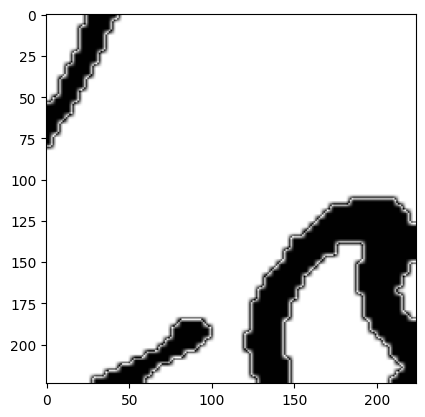

In [17]:
# Normalize Input Image
# evtl. use processor(img), but this returns an object with different dimensions
def tensor_to_image(t) -> Image:
    transform=ToPILImage()
    return transform(t)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
# in other processors, maybe use 'shortest_edge'
size = ( processor.size["height"], processor.size["width"] )
# JV suggests: do not normalize bc these are no food images
#_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
#_transforms = Compose([Resize(size), ToTensor(), normalize])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

print(size)
def transforms(examples):
    """Transform the image in the Dataset row."""
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

ds = ds.with_transform(transforms)
tensor = ds['train'][0]['pixel_values']
print(ds['train'][0]['pixel_values'])

img = tensor_to_image(tensor)
plt.imshow(img)
plt.show()

In [18]:
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # highest prediction per label index
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
model = AutoModelForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./local_checkpoints/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

train_results=trainer.train()

  0%|          | 0/129 [00:00<?, ?it/s]

{'loss': 1.0122, 'learning_rate': 3.846153846153846e-05, 'epoch': 0.23}
{'loss': 0.7523, 'learning_rate': 4.698275862068966e-05, 'epoch': 0.46}
{'loss': 0.6965, 'learning_rate': 4.267241379310345e-05, 'epoch': 0.69}
{'loss': 0.6555, 'learning_rate': 3.8362068965517246e-05, 'epoch': 0.92}


  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.6536355018615723, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 240.8429, 'eval_samples_per_second': 2.89, 'eval_steps_per_second': 0.183, 'epoch': 0.99}
{'loss': 0.6455, 'learning_rate': 3.405172413793103e-05, 'epoch': 1.15}
{'loss': 0.6435, 'learning_rate': 2.974137931034483e-05, 'epoch': 1.38}
{'loss': 0.6668, 'learning_rate': 2.543103448275862e-05, 'epoch': 1.61}
{'loss': 0.6263, 'learning_rate': 2.1120689655172415e-05, 'epoch': 1.84}


  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.6257754564285278, 'eval_accuracy': 0.6752873563218391, 'eval_runtime': 233.0592, 'eval_samples_per_second': 2.986, 'eval_steps_per_second': 0.189, 'epoch': 2.0}
{'loss': 0.6102, 'learning_rate': 1.6810344827586207e-05, 'epoch': 2.07}
{'loss': 0.6031, 'learning_rate': 1.25e-05, 'epoch': 2.3}
{'loss': 0.6148, 'learning_rate': 8.189655172413793e-06, 'epoch': 2.53}
{'loss': 0.6098, 'learning_rate': 3.8793103448275865e-06, 'epoch': 2.76}


  0%|          | 0/44 [00:00<?, ?it/s]

{'eval_loss': 0.6182489395141602, 'eval_accuracy': 0.6867816091954023, 'eval_runtime': 912.7553, 'eval_samples_per_second': 0.763, 'eval_steps_per_second': 0.048, 'epoch': 2.97}
{'train_runtime': 13930.7134, 'train_samples_per_second': 0.6, 'train_steps_per_second': 0.009, 'train_loss': 0.6718601995660353, 'epoch': 2.97}


TrainOutput(global_step=129, training_loss=0.6718601995660353, metrics={'train_runtime': 13930.7134, 'train_samples_per_second': 0.6, 'train_steps_per_second': 0.009, 'train_loss': 0.6718601995660353, 'epoch': 2.97})

In [23]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

NameError: name 'train_results' is not defined

In [21]:
classifier = pipeline("image-classification", model=model, image_processor=processor)

In [22]:
classifier = pipeline("image-classification", model=model, image_processor=processor)
participants = [ l['path'] for  l in random.sample(all_images, len(all_images))]
for img in participants:
    print(classifier(Image.open(img)))

[{'score': 0.6473792195320129, 'label': 'male'}, {'score': 0.33830058574676514, 'label': 'female'}, {'score': 0.014320144429802895, 'label': 'diverse'}]
[{'score': 0.6196789145469666, 'label': 'male'}, {'score': 0.3661889433860779, 'label': 'female'}, {'score': 0.014132222160696983, 'label': 'diverse'}]
[{'score': 0.7079015970230103, 'label': 'male'}, {'score': 0.2738308012485504, 'label': 'female'}, {'score': 0.018267588689923286, 'label': 'diverse'}]
[{'score': 0.6596652269363403, 'label': 'female'}, {'score': 0.3223387598991394, 'label': 'male'}, {'score': 0.017995942384004593, 'label': 'diverse'}]
[{'score': 0.575359046459198, 'label': 'male'}, {'score': 0.4050178825855255, 'label': 'female'}, {'score': 0.01962296850979328, 'label': 'diverse'}]
[{'score': 0.7369356751441956, 'label': 'male'}, {'score': 0.24796384572982788, 'label': 'female'}, {'score': 0.015100453048944473, 'label': 'diverse'}]
[{'score': 0.786034107208252, 'label': 'male'}, {'score': 0.19657739996910095, 'label': 

KeyboardInterrupt: 

In [12]:
#classifier = pipeline("image-classification", model=model, image_processor=processor)
#males = [ l['path'] for  l in random.sample(all_images, len(all_images)) if l['label'] == 'male' ][:20]
#for img in males:
#    print(classifier(Image.open(img)))

[{'score': 0.3824424147605896, 'label': 'male'}, {'score': 0.3365170359611511, 'label': 'female'}, {'score': 0.2810405492782593, 'label': 'diverse'}]
[{'score': 0.39737528562545776, 'label': 'male'}, {'score': 0.30959898233413696, 'label': 'female'}, {'score': 0.2930257320404053, 'label': 'diverse'}]


## Model Evaluation

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)